In [12]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [13]:
import os
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch
import torchvision
from glob import glob
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import torchvision.transforms as transform
from torch.utils.data import DataLoader,Dataset

#dataset: https://www.kaggle.com/datasets/dansbecker/cityscapes-image-pairs/data

class CityscapesDataset(Dataset):
    def __init__(self, image_dir, val_dir, cut_half = True, transform = None):
        self.image_dir = image_dir
        self.imgs = os.listdir(image_dir)
        self.val_dir = val_dir
        self.vals = os.listdir(image_dir)

        self.cut_half = cut_half
        self.transforms = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.imgs[idx])
        lab_name = os.path.join(self.val_dir, self.vals[idx])
        img = Image.open(os.path.join(self.image_dir, self.imgs[idx]))
        img_mask = Image.open(os.path.join(self.val_dir, self.vals[idx]))
        if self.cut_half:
            x_width, y_height = img_mask.size
            split = x_width / 2
            img = img.crop((split//2, 0, x_width - split//2, y_height))
            mask = img_mask.crop((split//2, 0, x_width - split//2, y_height))
            if self.transforms:
                img = self.transforms(img)
                mask = self.transforms(mask)
                return img, mask, img_name, lab_name


        return img_mask


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
transform_init = transform.Compose([
    transform.Resize((224,224)),
    transform.ToTensor()
])

# NEED TO SWITCH THIS
# SO THAT THEY ARE ALL EITHER SNOWY, RAINY, etc.

dataset = CityscapesDataset(image_dir='/content/drive/MyDrive/18786 Project/Fog_Data/Dense_Fog', val_dir = '/content/drive/MyDrive/18786 Project/Fog_Data/No_Fog', cut_half=True, transform=transform_init)
val_dataset = CityscapesDataset(image_dir='/content/drive/MyDrive/18786 Project/Fog_Data/Medium_Fog', val_dir = '/content/drive/MyDrive/18786 Project/Fog_Data/No_Fog', cut_half=True, transform=transform_init)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
valloader = DataLoader(val_dataset)
print(len(dataset), len(dataloader), len(valloader))

500 16 500


In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.is_available()

True

In [17]:
#https://blog.paperspace.com/writing-resnet-from-scratch-in-pytorch/#residual-block

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [18]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        self.deconv1 = nn.ConvTranspose2d(512,256, kernel_size = 3, stride = 2, padding = 1, dilation = 1, output_padding = 1)
        self.deconv2 = nn.ConvTranspose2d(256,128, kernel_size = 3, stride = 2, padding = 1, dilation = 1, output_padding = 1)
        self.deconv3 = nn.ConvTranspose2d(128,64, kernel_size = 3, stride = 2, padding = 1, dilation = 1, output_padding = 1)
        self.deconv4 = nn.ConvTranspose2d(64,32, kernel_size = 3, stride = 2, padding = 1, dilation = 1, output_padding = 1)
        self.deconv5 = nn.ConvTranspose2d(32,3, kernel_size = 3, stride = 2, padding = 1, dilation = 1, output_padding = 1)
        self.bn1 = nn.BatchNorm2d(256)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(32)
        self.bn5 = nn.BatchNorm2d(3)
        self.relu = nn.ReLU()


    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x):

        x = self.conv1(x)

        x = self.maxpool(x)

        x = self.layer0(x)

        x = self.layer1(x)

        x = self.layer2(x)

        x = self.layer3(x)
        #print(np.shape(x))
        # From here we want reverses
        x = self.deconv1(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.deconv2(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.deconv3(x)
        x = self.relu(x)
        x = self.bn3(x)
        x = self.deconv4(x)
        x = self.relu(x)
        x = self.bn4(x)
        x = self.deconv5(x)
        x = self.relu(x)
        x = self.bn5(x)

        #print(np.shape(x))

        #So now after having converted. We have

        return x




In [19]:


model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)


from torchsummary import summary
summary(model, (3,224,224))

epochs = 10

loss_func = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

train_acc = []
val_acc = []
train_loss = []
val_loss = []

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,928
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,928
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
    ResidualBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,928
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [20]:
for i in range(epochs):

    trainloss = 0
    valloss = 0

    for img,label, img_name, val_name in tqdm(dataloader):
        #print("new image")
        optimizer.zero_grad()
        img = img.to(device)
        label = label.to(device)
        output = model(img)
        loss = loss_func(output,label)
        loss.backward()
        optimizer.step()
        trainloss+=loss.item()

    train_loss.append(trainloss/len(dataloader))

    for img,label, img_name, val_name in tqdm(valloader):
        img = img.to(device)
        label = label.to(device)
        output = model(img)
        loss = loss_func(output,label)
        valloss+=loss.item()

    val_loss.append(valloss/len(valloader))

    print("epoch : {} ,train loss : {} ,valid loss : {} ".format(i,train_loss[-1],val_loss[-1]))


100%|██████████| 500/500 [04:51<00:00,  1.72it/s]


epoch : 0 ,train loss : 1.0866213887929916 ,valid loss : 0.9662104054689408 


100%|██████████| 500/500 [01:42<00:00,  4.90it/s]


epoch : 1 ,train loss : 0.8545287437736988 ,valid loss : 0.7712891964912415 


100%|██████████| 500/500 [01:42<00:00,  4.87it/s]


epoch : 2 ,train loss : 0.68178516253829 ,valid loss : 0.6208065321445465 


100%|██████████| 500/500 [01:42<00:00,  4.89it/s]


epoch : 3 ,train loss : 0.5483470074832439 ,valid loss : 0.5027950330376625 


100%|██████████| 500/500 [01:40<00:00,  4.97it/s]


epoch : 4 ,train loss : 0.44365509040653706 ,valid loss : 0.4094410783648491 


100%|██████████| 500/500 [01:40<00:00,  4.96it/s]


epoch : 5 ,train loss : 0.3607595767825842 ,valid loss : 0.3351825919151306 


100%|██████████| 500/500 [01:42<00:00,  4.90it/s]


epoch : 6 ,train loss : 0.29503900185227394 ,valid loss : 0.2760192668437958 


100%|██████████| 500/500 [01:44<00:00,  4.80it/s]


epoch : 7 ,train loss : 0.24235907196998596 ,valid loss : 0.22882338187098503 


100%|██████████| 500/500 [01:39<00:00,  5.00it/s]


epoch : 8 ,train loss : 0.20044435933232307 ,valid loss : 0.19109304192662238 


100%|██████████| 500/500 [01:39<00:00,  5.03it/s]

epoch : 9 ,train loss : 0.16712869331240654 ,valid loss : 0.1608860950022936 


In [21]:
torch.save(model, 'model_r_defogger.pth')

 10%|▉         | 49/500 [00:10<01:23,  5.38it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


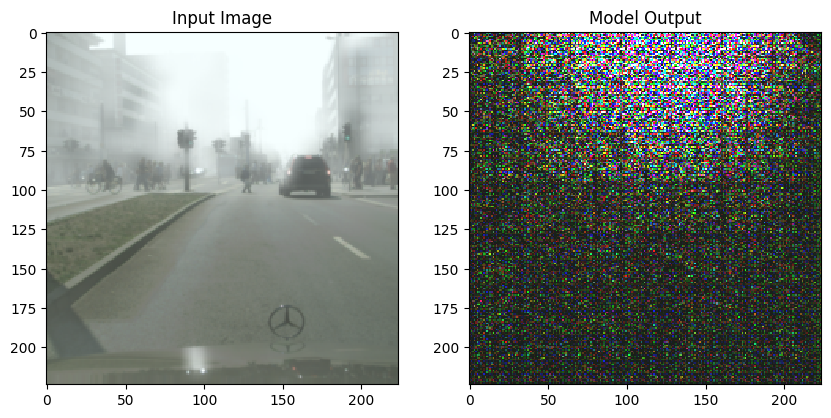

 20%|█▉        | 99/500 [00:21<01:19,  5.06it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


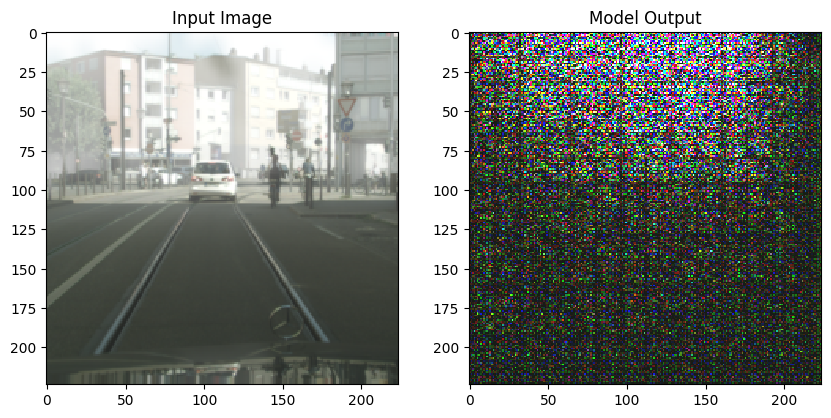

 30%|██▉       | 149/500 [00:32<01:07,  5.18it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


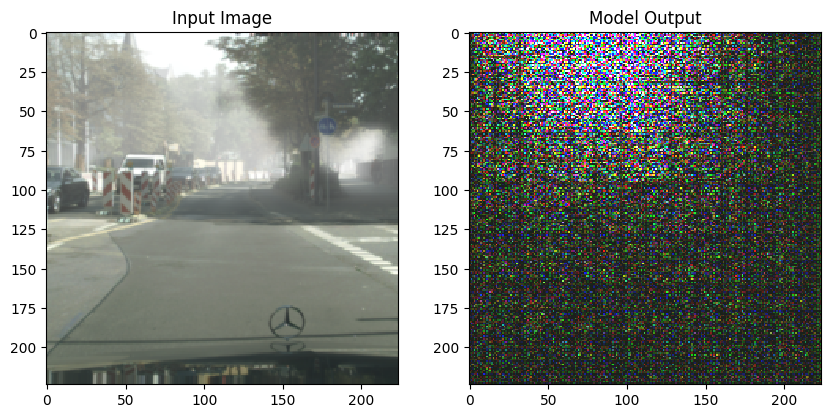

 40%|███▉      | 199/500 [00:43<00:58,  5.16it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


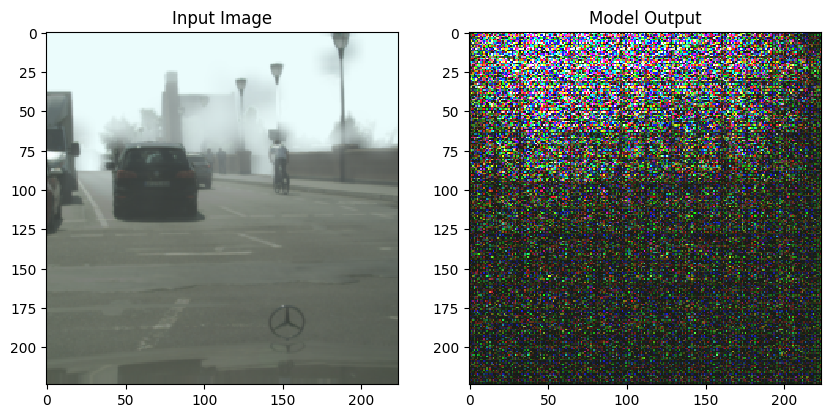

 50%|████▉     | 249/500 [00:54<01:06,  3.77it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


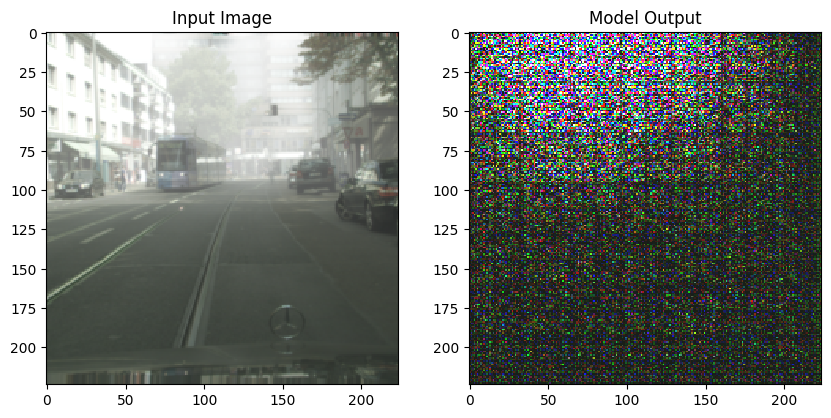

 60%|█████▉    | 299/500 [01:04<00:42,  4.74it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


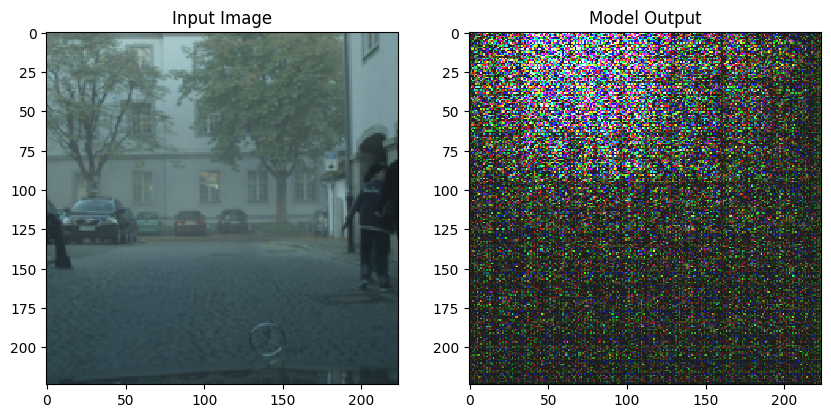

 70%|██████▉   | 349/500 [01:16<00:29,  5.10it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


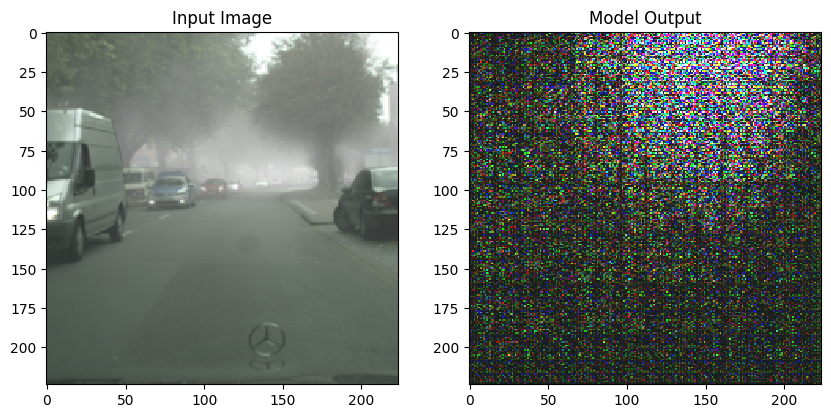

 80%|███████▉  | 399/500 [01:27<00:26,  3.85it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


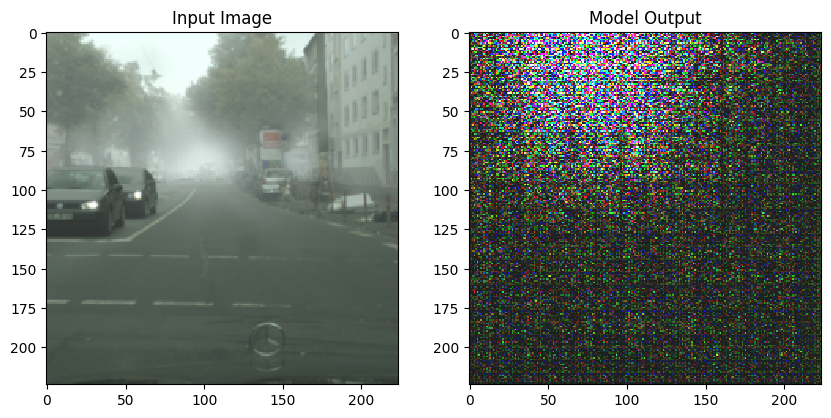

 90%|████████▉ | 449/500 [01:39<00:09,  5.10it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


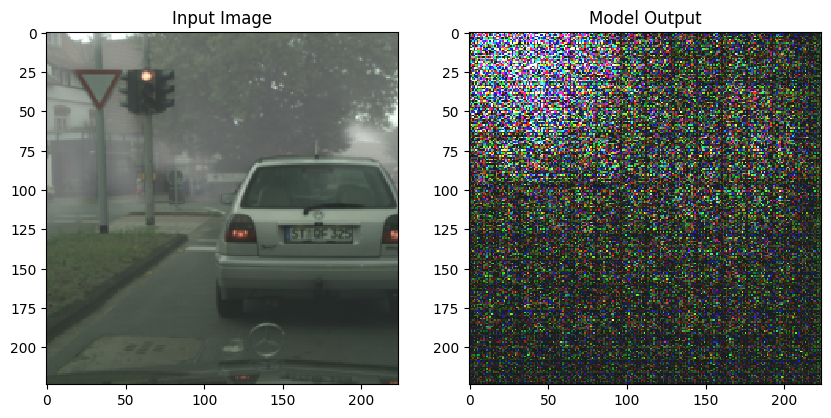

100%|█████████▉| 499/500 [01:51<00:00,  4.91it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


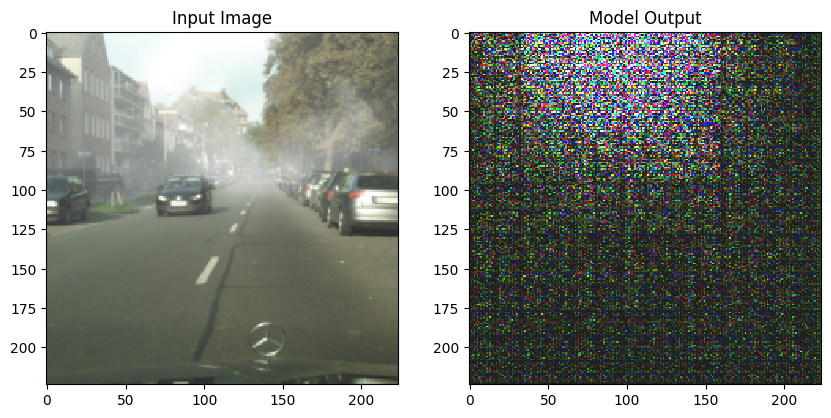

100%|██████████| 500/500 [01:52<00:00,  4.46it/s]


In [22]:
import cv2
idx = 0


for img,label, img_name, val_name in tqdm(valloader):
    idx +=1
    img = img.to(device)
    label = label.to(device)
    output = model(img)

    img_cpu = img.cpu()
    output_cpu = output.cpu()
    label_cpu = label.cpu()

    img_to_show = img_cpu.squeeze().numpy()
    img_to_show = np.transpose(img_to_show, (1, 2, 0))

    output_to_show = output_cpu[0].detach().numpy()
    #print(output_to_show.shape)
    output_to_show = np.transpose(output_to_show, (1, 2, 0))


    if idx % 50 == 0:
      plt.figure(figsize=(10, 10))
      plt.subplot(1, 2, 1)
      plt.imshow(img_to_show, interpolation='none')
      plt.title("Input Image")

      plt.subplot(1, 2, 2)
      # Assuming output is also an image
      plt.imshow(output_to_show, interpolation='none')  # This line may need to change based on the type of output
      plt.title("Model Output")

      plt.show()

    #cv2.imwrite("filename.png", img_to_show*225)


    img_filename = os.path.join("/content/in", f"image_{idx}.jpg")
    output_filename = os.path.join("/content/out", f"output_{idx}.jpg")

    cv2.imwrite(img_filename, img_to_show*225)
    cv2.imwrite(output_filename, output_to_show*225)